In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
from tqdm.notebook import tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import load_img

## Load the model

In [5]:
train_dir = "/kaggle/input/facial-expression-dataset/train/train"
test_dir = "/kaggle/input/facial-expression-dataset/test/test"

In [6]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(os.path.join(directory,label)):
            image_path=os.path.join(directory,label,filename)
            image_paths.append(image_path)
            labels.append(label)
        print(label,'completed')
    return image_paths, labels

In [7]:
# convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise completed
fear completed
angry completed
neutral completed
sad completed
disgust completed
happy completed


,image,label
0,/kaggle/input/facial-expression-dataset/train/...,happy
1,/kaggle/input/facial-expression-dataset/train/...,happy
2,/kaggle/input/facial-expression-dataset/train/...,sad
3,/kaggle/input/facial-expression-dataset/train/...,angry
4,/kaggle/input/facial-expression-dataset/train/...,angry


In [8]:
test = pd.DataFrame()
test['image'], test['label']= load_dataset(test_dir)
test.head()

surprise completed
fear completed
angry completed
neutral completed
sad completed
disgust completed
happy completed


,image,label
0,/kaggle/input/facial-expression-dataset/test/t...,surprise
1,/kaggle/input/facial-expression-dataset/test/t...,surprise
2,/kaggle/input/facial-expression-dataset/test/t...,surprise
3,/kaggle/input/facial-expression-dataset/test/t...,surprise
4,/kaggle/input/facial-expression-dataset/test/t...,surprise


## Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

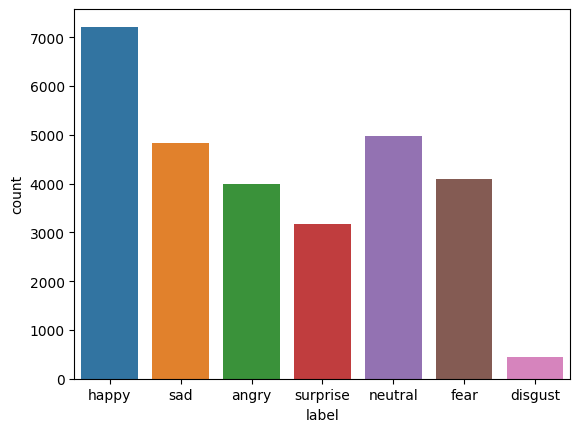

In [9]:
sns.countplot(data=train, x='label')

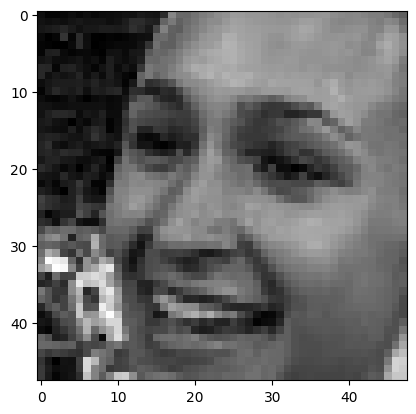

In [10]:
from PIL import Image
image = Image.open(train['image'][0])
plt.imshow(image, cmap='gray');

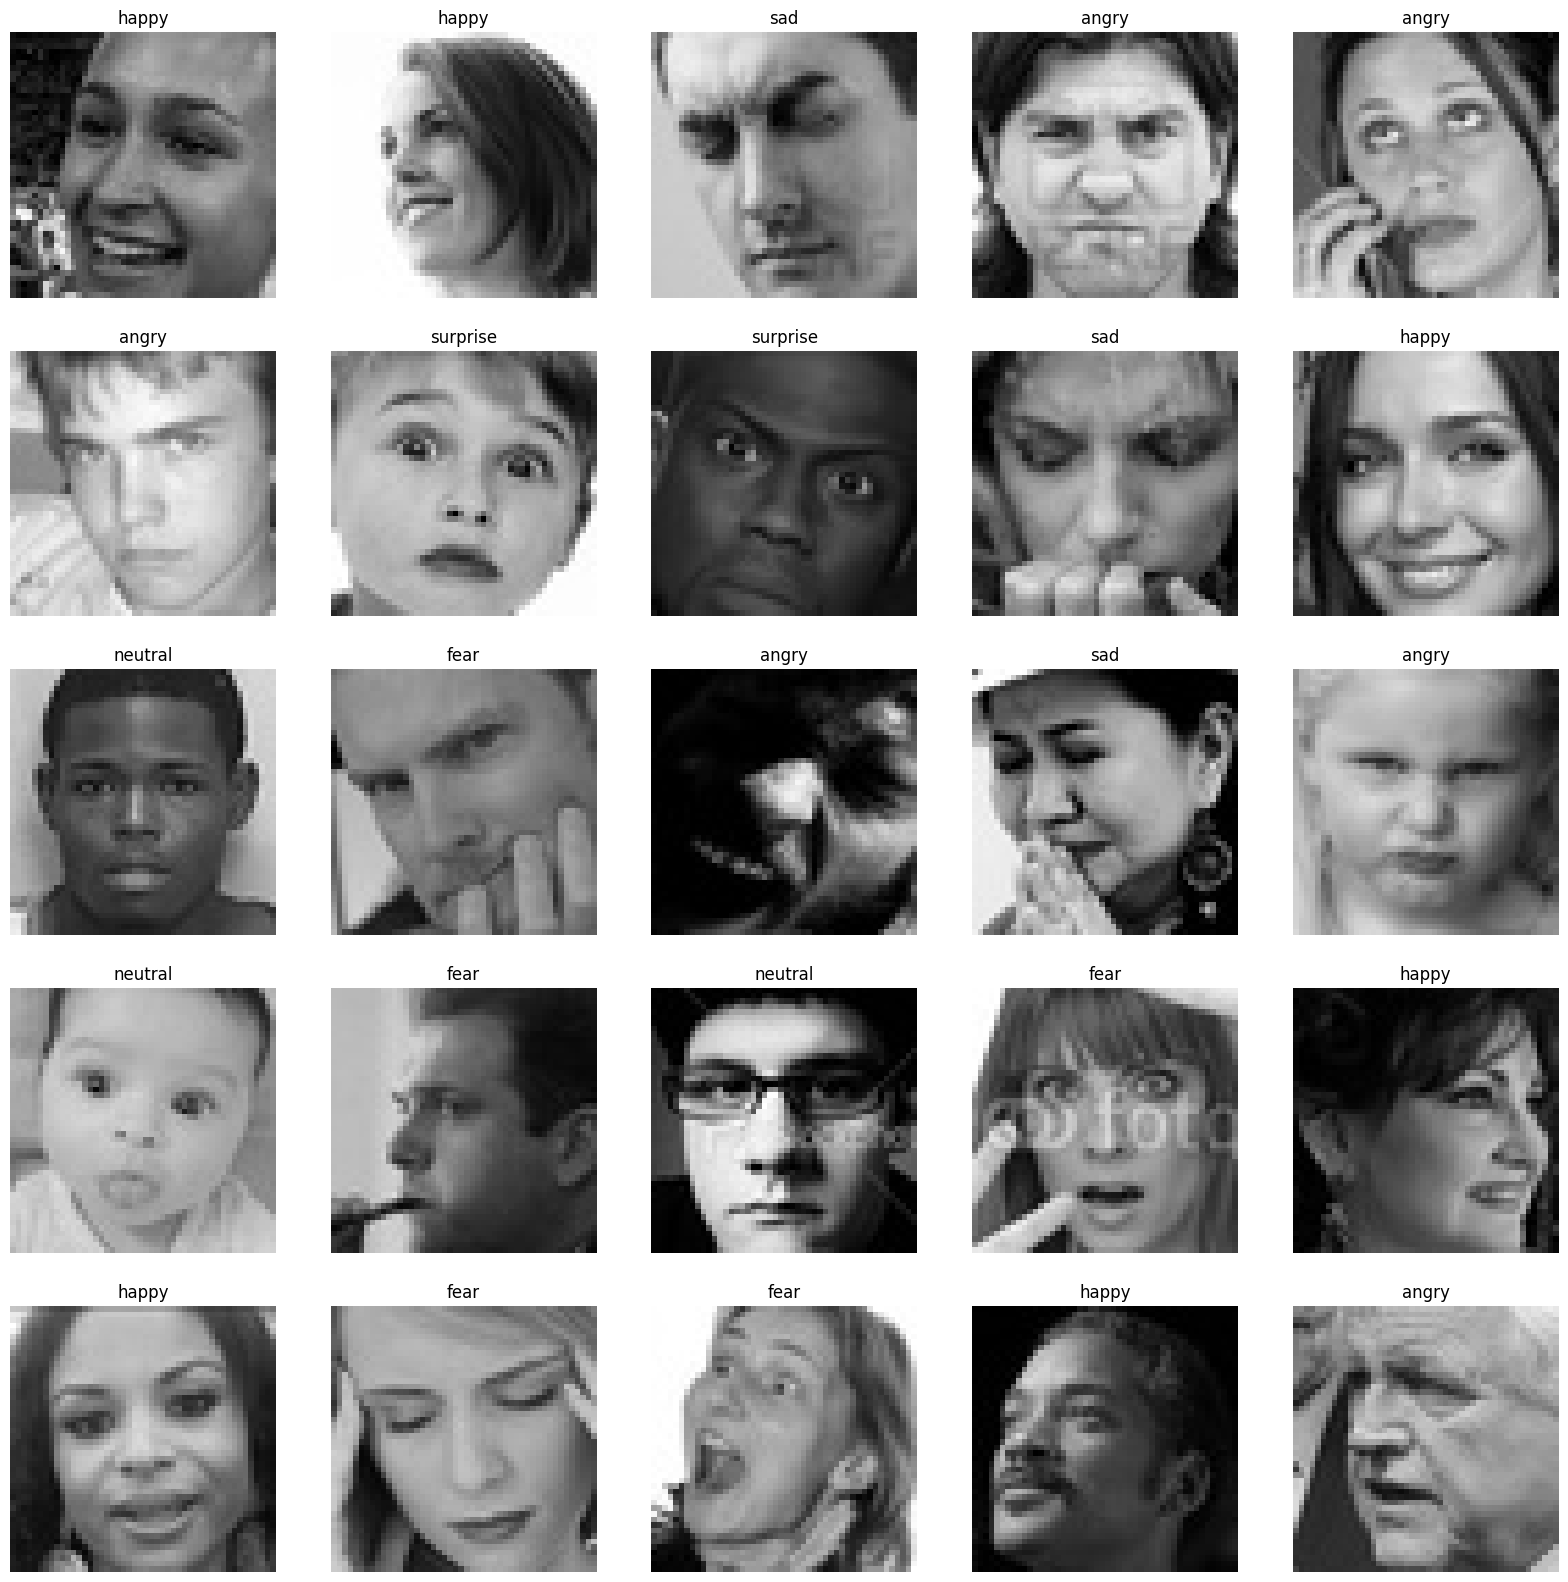

In [11]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img_array = np.array(img) / 255.0  # Normalize pixel values
        features.append(img_array)

    features = np.array(features)
    print("Original shape:", features.shape)

    try:
        features = features.reshape(len(features), 48, 48, 3)
        print("Reshaped successfully.")
    except ValueError as e:
        print(f"Error during reshape: {e}")

    return features

In [13]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

Original shape: (28709, 48, 48, 3)
Reshaped successfully.


In [14]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

Original shape: (7178, 48, 48, 3)
Reshaped successfully.


In [15]:
min_value = np.min(train_features)
max_value = np.max(train_features)

print(f"Minimum pixel value: {min_value}")
print(f"Maximum pixel value: {max_value}")

Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [16]:
min_value = np.min(test_features)
max_value = np.max(test_features)

print(f"Minimum pixel value: {min_value}")
print(f"Maximum pixel value: {max_value}")

Minimum pixel value: 0.0
Maximum pixel value: 1.0


In [17]:
X_train = train_features
X_test = test_features

In [18]:
 ## convert label to integar
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train['label'])

y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [19]:
y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

In [20]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [21]:
input_shape = (48,48,3)
output_class = 7

## Model creation

In [22]:
model = Sequential()

# Convolutional block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_class, activation='softmax'))


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 256)       0

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=X_train, y=y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
102/449 [=====>........................] - ETA: 8:18 - loss: 1.8359 - accuracy: 0.2374

In [ ]:
model.fit(x=X_train, y=y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range((len(acc)))

plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs, val_acc,'r',label='Validation Accuracy')
plt.title("Accuracy Graph")
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs, val_loss,'r',label='Validation loss')
plt.title("Loss Graph")
plt.legend()
plt.figure()
plt.show()

## Test with image data

In [ ]:
import random

image_index = random.randint(0, len(test))
print("original output:", test['label'][image_index])
pred = model.predict(X_test[image_index].reshape(1, 48, 48, 3))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction output:", prediction_label)
plt.imshow(X_test[image_index].reshape(48, 48, 3), cmap='gray')
plt.show()

In [ ]:
image_index = random.randint(0, len(test))
print("original output:", test['label'][image_index])
pred = model.predict(X_test[image_index].reshape(1, 48, 48, 3))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction output:", prediction_label)
plt.imshow(X_test[image_index].reshape(48, 48, 3), cmap='viridis')  
plt.show()

In [ ]:
image_index = random.randint(0, len(test))
print("original output:", test['label'][image_index])
pred = model.predict(X_test[image_index].reshape(1, 48, 48, 3))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction output:", prediction_label)
plt.imshow(X_test[image_index].reshape(48, 48, 3), cmap='gray')  
plt.show()

In [ ]:
image_index = random.randint(0, len(test))
print("original output:", test['label'][image_index])
pred = model.predict(X_test[image_index].reshape(1, 48, 48, 3))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Prediction output:", prediction_label)
plt.imshow(X_test[image_index].reshape(48, 48, 3), cmap='viridis')  
plt.show()